In [1]:
# Importing libraries
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt

In [184]:
#Read the map
Planck_SMICA=hp.read_map('/home/akozameh/COM_CMB_IQU-smica_2048_R3.00_hm2.fits')

In [185]:
#Read the mask
mask=hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

Since we are interested in large-angular scale, the maps were degraded at NSIDE = 64 and NSIDE=16

In [186]:
#Planck SMICA degraded map
Planck_1=hp.pixelfunc.ud_grade(Planck_SMICA, 64)       #degraded maps at NSIDE=64
Planck_2=hp.pixelfunc.ud_grade(Planck_SMICA, 16)       #degraded maps at NSIDE=16
mask_deg=hp.pixelfunc.ud_grade(mask,64)                #degraded mask at NSIDE=16

In [51]:
# Creating new mask in equatorial coordinates
NSIDE = 64
ipix=hp.nside2npix(NSIDE)
m=np.zeros(ipix) #mask


type(ipix)

int

In [124]:
# I make a list of thetas and phi 
thetas=[]
phis=[]
for j in range(0,(ipix)):
    theta,phi=(hp.pix2ang(NSIDE, j))
    thetas.append(theta)
    phis.append(phi)


In [125]:
# it makes theta and phi array by numpy array
theta_a=np.array(thetas)
phis_a=np.array(phis)

In [126]:
phis_a

array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
       5.49778714])

In [127]:
# Converting the theta, phi in r.a and decl.
decl=np.rad2deg(0.5 * np.pi - theta_a)
ra = np.rad2deg(phis_a)

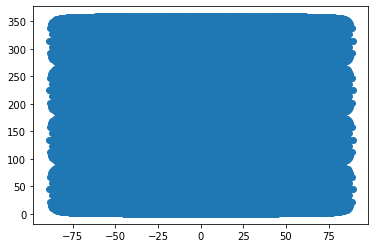

In [129]:
plt.scatter(decl,ra)

In [164]:
# Selecting the survey class
clas1=np.where(decl>-70)# and decl<=30)
clas2=np.where(decl<30)
clas3=clas1 & clas2
#clas=clas1 clas2

TypeError: unsupported operand type(s) for &: 'tuple' and 'tuple'

In [158]:
cond1 = decl>-70
cond2 = decl<30
mask  = cond1 & cond2

In [161]:
type(mask)

numpy.ndarray

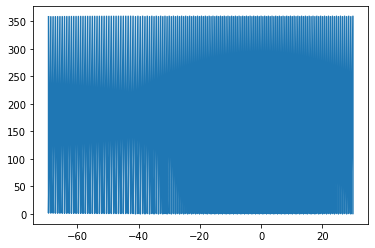

In [160]:
plt.plot(decl[mask],ra[mask])

In [173]:
# Convert the decl and r.a in theta and phi
theta = 0.5 * np.pi - np.deg2rad(decl[mask])
phi = np.deg2rad(ra[mask])


In [172]:
# It Converts theta and phi in number of pixeles
pix=hp.ang2pix(NSIDE,theta,phi)
pix

array([12160, 12161, 12162, ..., 47637, 47638, 47639])

In [175]:
m[pix]=1

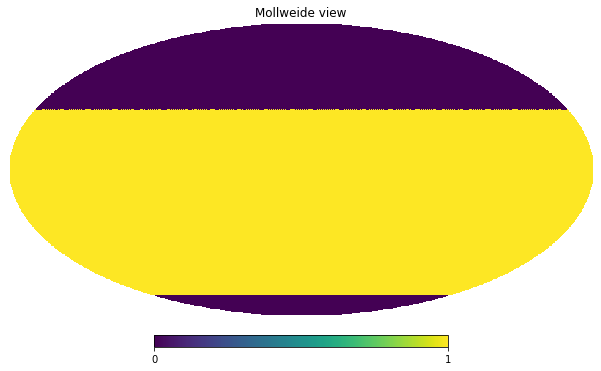

In [176]:
hp.mollview(m)

In [179]:
rot=hp.Rotator(coord=['C','G'])  # Transforms equatorial to galactic coordinates

In [180]:
# Rotate the map to galactic coordinates
m=rot.rotate_map_pixel(m) 

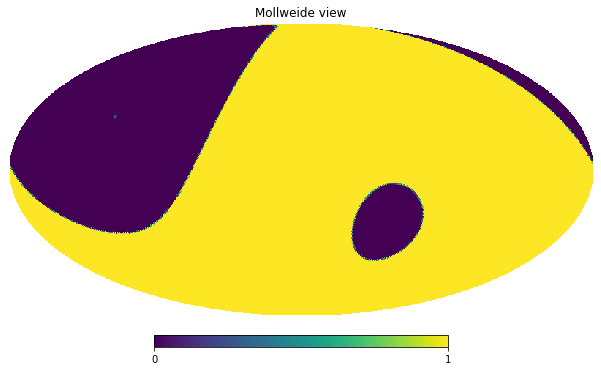

In [181]:
hp.mollview(m)

In [187]:
# Total mask
mask_total=m * mask_deg

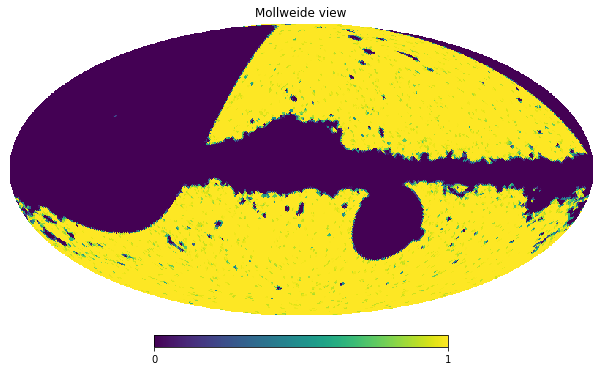

In [188]:
# Total mask is shown
hp.mollview(mask_total)

# In this part I will compute the cls and pseudo cls

In [192]:
# An NmtField object contains all the information describing the fields to correlate, 
# including their observed maps, masks and contaminant templates.
f_0=nmt.NmtField(mask_total, [Planck_1])

In [194]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b = nmt.NmtBin.from_nside_linear(NSIDE, 4)

In [197]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_00 = nmt.compute_full_master(f_0, f_0, b)

In [199]:
# Shape of the pseudo Cls
cl_00.shape
cl_00[0]

array([2.73870004e-10, 7.95586410e-11, 3.47502078e-11, 2.64609011e-11,
       9.79085030e-12, 8.40661759e-12, 8.33860878e-12, 7.62519312e-12,
       5.14995471e-12, 5.30769575e-12, 3.89978741e-12, 3.18839498e-12,
       2.91940263e-12, 3.07885009e-12, 2.49810862e-12, 2.60567596e-12,
       2.22777428e-12, 2.03155249e-12, 1.88941921e-12, 1.65489922e-12,
       1.85119975e-12, 1.54355322e-12, 1.43692343e-12, 1.22968077e-12,
       1.44338089e-12, 1.28120870e-12, 1.27979471e-12, 1.10429020e-12,
       1.25798334e-12, 1.15761655e-12, 1.09121683e-12, 8.79655736e-13,
       9.05369847e-13, 1.00911438e-12, 9.34879637e-13, 8.70779668e-13,
       7.19056862e-13, 7.76177151e-13, 7.43563867e-13, 7.62852704e-13,
       6.01680543e-13, 7.00142424e-13, 6.12719343e-13, 5.90302113e-13,
       5.81677468e-13, 5.90841171e-13, 6.71627109e-13])

In [209]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el = b.get_effective_ells()
el.shape

(47,)

In [203]:
dl=cl_00[0]*[(1e6)**(2)]*el*(el+1)/2/np.pi

In [204]:
# Interpolation of the pseudo Dls
from scipy.interpolate import interp1d

In [205]:
# I define the interpolation with x**3
f=interp1d(el, dl, kind='cubic') 

In [210]:
# I define my news l
lnew=np.linspace(4, 47, 47)
# oncatenate

In [212]:
#pdl is the interpolation of the pseudo Dls
pdl_int=f(lnew)

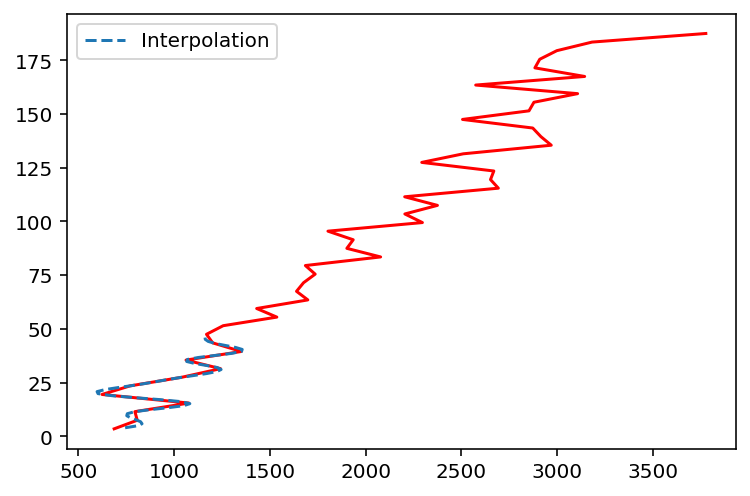

In [217]:
plt.plot(dl,el,'r')
plt.plot(pdl_int, lnew,'--', label='Interpolation')
plt.legend()

In [201]:
# In this part I compute the correlation function 
# Importing libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os

In [202]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower, correlations
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.5 installed at /home/akozameh/miniconda3/envs/CMB/lib/python3.10/site-packages/camb
